## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do mch of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

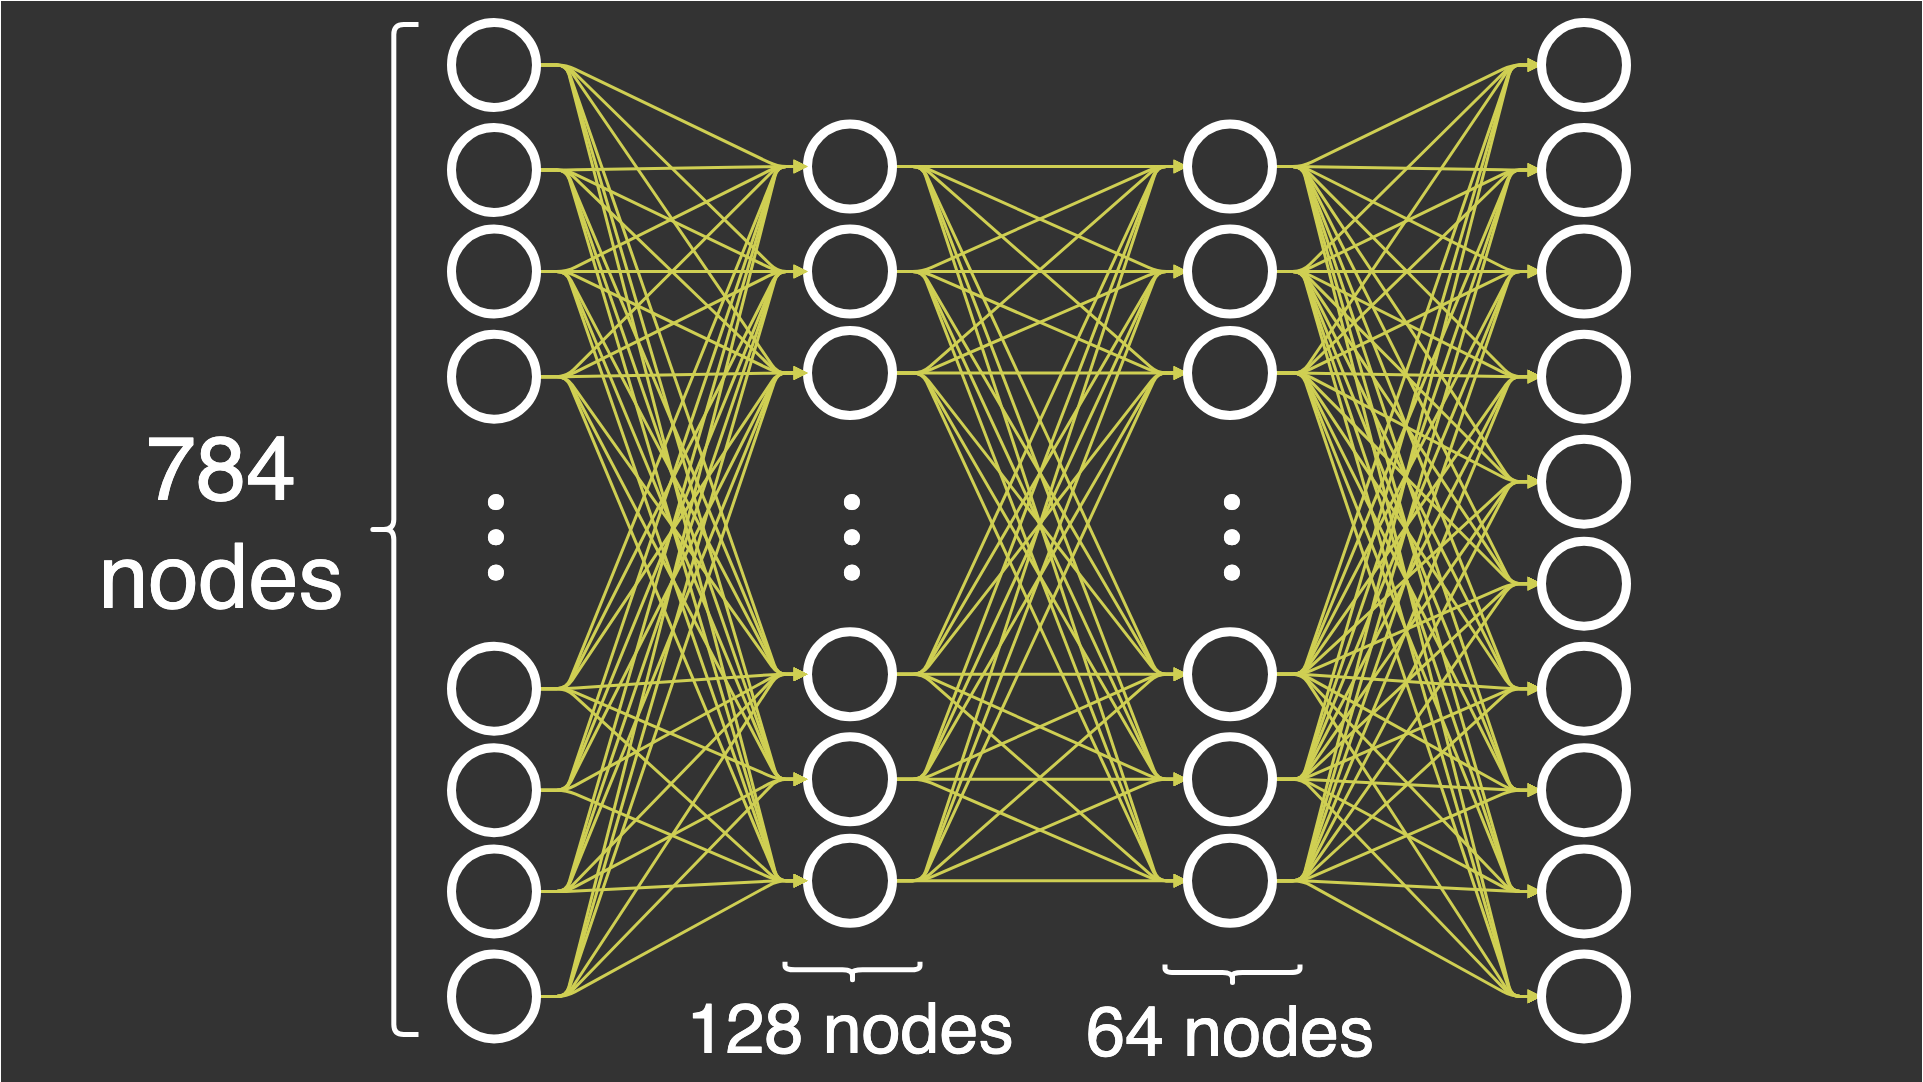

## Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem. We will reuse some code from one of the other articles on [Activation Functions Explained](https://mlfromscratch.com/activation-functions-explained/).

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split

(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()

x = np.concatenate([x_train_raw, x_test_raw], axis=0)
y = np.concatenate([y_train_raw, y_test_raw], axis=0)

x = x.reshape(-1, 784).astype("float32") / 255.0
y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(59500, 784)
(10500, 784)
(59500, 10)
(10500, 10)


In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
print(y[3])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## 4-layer Neural Network with NumPy

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 42.26s, Accuracy: 21.57%
Epoch: 1, Time Spent: 42.26s, Accuracy: 21.39%
Epoch: 1, Time Spent: 42.26s, loss: 0.34
Epoch: 1, Time Spent: 42.26s, loss: 0.31
-------------------------------------------------------------
Epoch: 2, Time Spent: 78.82s, Accuracy: 24.80%
Epoch: 2, Time Spent: 78.82s, Accuracy: 25.39%
Epoch: 2, Time Spent: 78.82s, loss: 0.34
Epoch: 2, Time Spent: 78.82s, loss: 0.30
-------------------------------------------------------------
Epoch: 3, Time Spent: 116.81s, Accuracy: 25.80%
Epoch: 3, Time Spent: 116.81s, Accuracy: 26.89%
Epoch: 3, Time Spent: 116.81s, loss: 0.34
Epoch: 3, Time Spent: 116.81s, loss: 0.29
-------------------------------------------------------------
Epoch: 4, Time Spent: 152.49s, Accuracy: 28.20%
Epoch: 4, Time Spent: 152.49s, Accuracy: 29.29%
Epoch: 4, Time Spent: 152.49s, loss: 0.34
Epoch: 4, Time Spent: 152.49s, loss: 0.28
-------------------------------------------------------------
Epoch: 5, Time Spent: 188.39s, Accuracy:

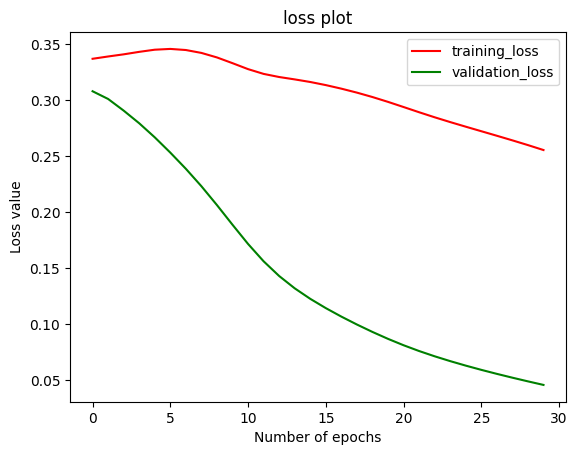

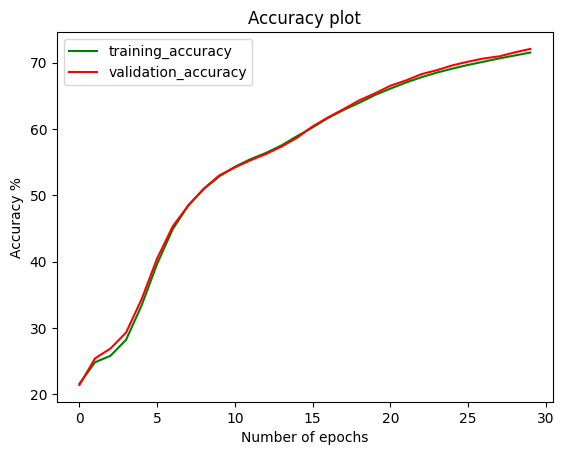

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=30, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)


###**Observation-1**

The base **DNN model** performed poorly compared to the others, with training and validation accuracies around **71–72%**. This clearly indicates underfitting. The network lacks depth or capacity to learn meaningful patterns from the data. Both accuracies being almost equal shows the model is not complex enough rather than overfitting.

Epoch: 1, Time Spent: 36.42s, Accuracy: 75.03%
Epoch: 1, Time Spent: 36.42s, Accuracy: 75.61%
Epoch: 1, Time Spent: 36.42s, loss: 0.08
Epoch: 1, Time Spent: 36.42s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 72.74s, Accuracy: 78.61%
Epoch: 2, Time Spent: 72.74s, Accuracy: 79.41%
Epoch: 2, Time Spent: 72.74s, loss: 0.04
Epoch: 2, Time Spent: 72.74s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 109.11s, Accuracy: 86.33%
Epoch: 3, Time Spent: 109.11s, Accuracy: 87.55%
Epoch: 3, Time Spent: 109.11s, loss: 0.04
Epoch: 3, Time Spent: 109.11s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 145.52s, Accuracy: 89.93%
Epoch: 4, Time Spent: 145.52s, Accuracy: 90.53%
Epoch: 4, Time Spent: 145.52s, loss: 0.03
Epoch: 4, Time Spent: 145.52s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 181.89s, Accuracy:

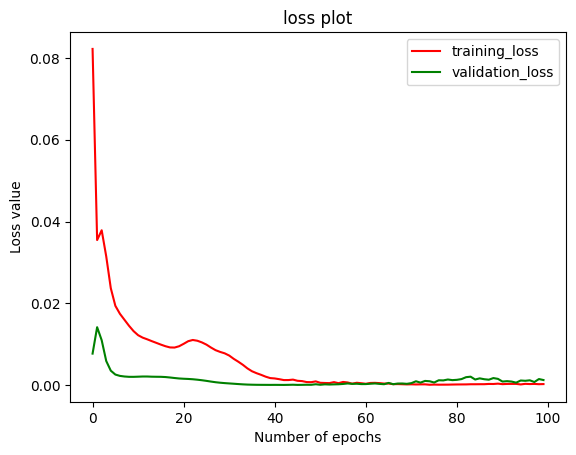

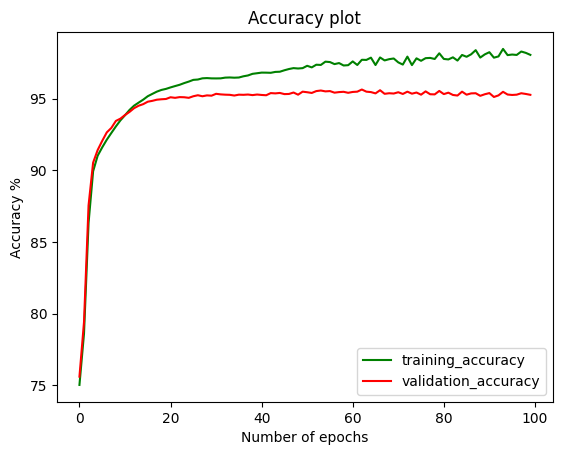

In [ ]:
dnn1 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.05)
dnn1.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-2**

**DNN1** achieved a training accuracy of **98.05%** and a validation accuracy of **95.26%**, making it one of the stronger models in the experiment. The small gap of about **2.8%** between training and validation accuracy indicates **minor overfitting**, but not severe enough to affect generalization significantly. Overall, the model performs reliably, and the chosen architecture and hyperparameters appear to be effective.

Epoch: 1, Time Spent: 37.16s, Accuracy: 59.78%
Epoch: 1, Time Spent: 37.16s, Accuracy: 59.82%
Epoch: 1, Time Spent: 37.16s, loss: 0.31
Epoch: 1, Time Spent: 37.16s, loss: 0.23
-------------------------------------------------------------
Epoch: 2, Time Spent: 74.32s, Accuracy: 65.94%
Epoch: 2, Time Spent: 74.32s, Accuracy: 66.31%
Epoch: 2, Time Spent: 74.32s, loss: 0.29
Epoch: 2, Time Spent: 74.32s, loss: 0.13
-------------------------------------------------------------
Epoch: 3, Time Spent: 111.39s, Accuracy: 72.17%
Epoch: 3, Time Spent: 111.40s, Accuracy: 72.60%
Epoch: 3, Time Spent: 111.40s, loss: 0.24
Epoch: 3, Time Spent: 111.40s, loss: 0.07
-------------------------------------------------------------
Epoch: 4, Time Spent: 148.12s, Accuracy: 75.31%
Epoch: 4, Time Spent: 148.12s, Accuracy: 75.54%
Epoch: 4, Time Spent: 148.12s, loss: 0.18
Epoch: 4, Time Spent: 148.12s, loss: 0.03
-------------------------------------------------------------
Epoch: 5, Time Spent: 185.19s, Accuracy:

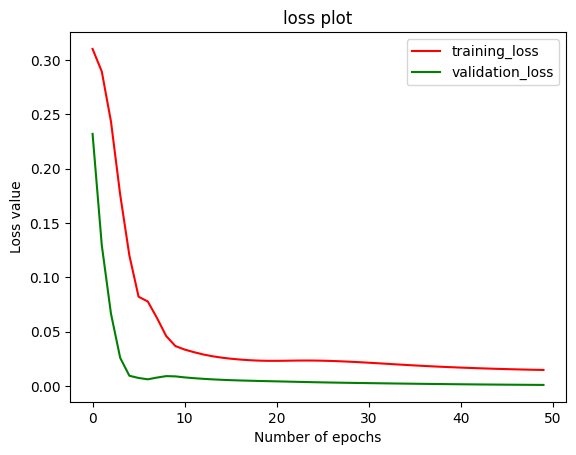

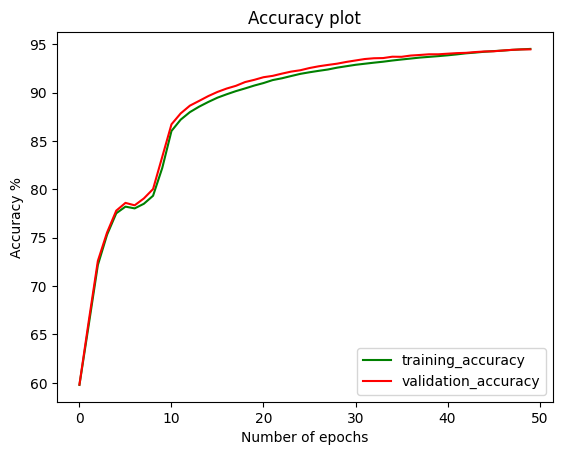

In [ ]:
dnn2 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.01)
dnn2.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-3**

**DNN2** reached around **94.5%** accuracy for both training and validation. The closeness of these values means the model is stable and **not overfitting**, but it lacks the complexity needed to **push accuracy** further. It performs reasonably well but is clearly weaker than the top-performing models.



Epoch: 1, Time Spent: 37.12s, Accuracy: 57.05%
Epoch: 1, Time Spent: 37.12s, Accuracy: 56.86%
Epoch: 1, Time Spent: 37.12s, loss: 0.36
Epoch: 1, Time Spent: 37.12s, loss: 0.19
-------------------------------------------------------------
Epoch: 2, Time Spent: 73.87s, Accuracy: 63.90%
Epoch: 2, Time Spent: 73.87s, Accuracy: 64.03%
Epoch: 2, Time Spent: 73.87s, loss: 0.31
Epoch: 2, Time Spent: 73.87s, loss: 0.15
-------------------------------------------------------------
Epoch: 3, Time Spent: 110.50s, Accuracy: 70.93%
Epoch: 3, Time Spent: 110.50s, Accuracy: 71.22%
Epoch: 3, Time Spent: 110.50s, loss: 0.24
Epoch: 3, Time Spent: 110.50s, loss: 0.11
-------------------------------------------------------------
Epoch: 4, Time Spent: 147.44s, Accuracy: 75.41%
Epoch: 4, Time Spent: 147.44s, Accuracy: 76.26%
Epoch: 4, Time Spent: 147.44s, loss: 0.17
Epoch: 4, Time Spent: 147.44s, loss: 0.06
-------------------------------------------------------------
Epoch: 5, Time Spent: 184.29s, Accuracy:

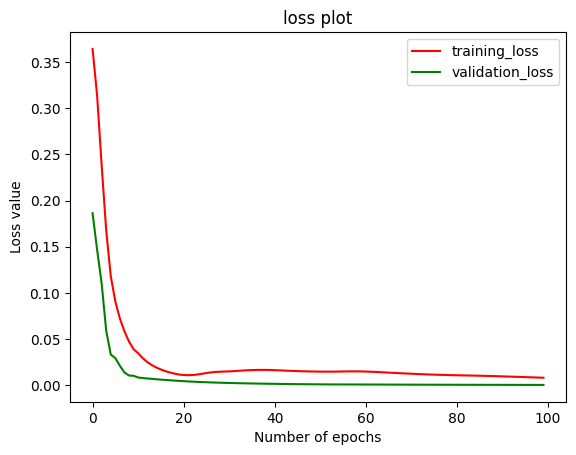

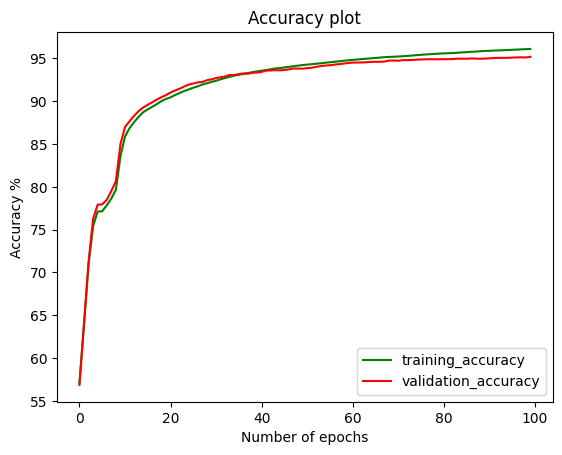

In [ ]:
dnn3 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01)
dnn3.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-4**

**DNN3** improved further by achieving **96.10%** training and **95.17%** validation accuracy. The small performance gap shows balanced learning. It captures the patterns well but does not reach the accuracy achieved by DNN1 or DNN4. This model performs consistently but has **room for improvement**.

Epoch: 1, Time Spent: 39.11s, Accuracy: 78.59%
Epoch: 1, Time Spent: 39.11s, Accuracy: 79.31%
Epoch: 1, Time Spent: 39.11s, loss: 0.08
Epoch: 1, Time Spent: 39.11s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 79.91s, Accuracy: 87.64%
Epoch: 2, Time Spent: 79.91s, Accuracy: 88.66%
Epoch: 2, Time Spent: 79.91s, loss: 0.08
Epoch: 2, Time Spent: 79.91s, loss: 0.02
-------------------------------------------------------------
Epoch: 3, Time Spent: 118.58s, Accuracy: 90.09%
Epoch: 3, Time Spent: 118.58s, Accuracy: 90.65%
Epoch: 3, Time Spent: 118.58s, loss: 0.05
Epoch: 3, Time Spent: 118.58s, loss: 0.02
-------------------------------------------------------------
Epoch: 4, Time Spent: 157.13s, Accuracy: 91.57%
Epoch: 4, Time Spent: 157.13s, Accuracy: 92.05%
Epoch: 4, Time Spent: 157.13s, loss: 0.03
Epoch: 4, Time Spent: 157.13s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 196.99s, Accuracy:

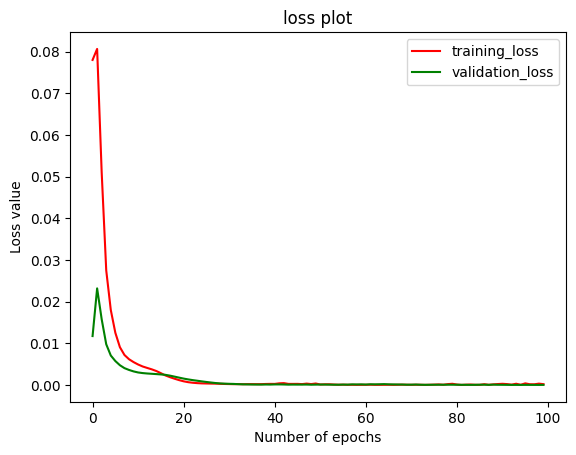

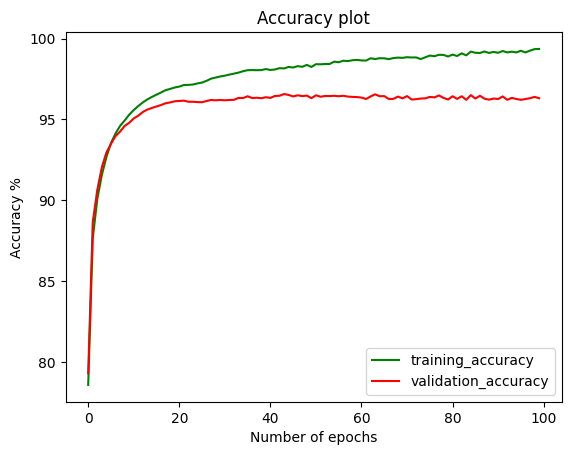

In [ ]:
dnn4 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.07)
dnn4.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-5**

**DNN4** reached **98.82%** training accuracy and **95.70%** validation accuracy, making it one of the **best-performing models** in the entire set. The validation accuracy is the highest overall, showing excellent generalization. The architecture and learning rate worked very effectively, and the model represents the most optimal configuration.

Epoch: 1, Time Spent: 67.88s, Accuracy: 77.29%
Epoch: 1, Time Spent: 67.88s, Accuracy: 77.39%
Epoch: 1, Time Spent: 67.88s, loss: 0.07
Epoch: 1, Time Spent: 67.88s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 136.39s, Accuracy: 86.36%
Epoch: 2, Time Spent: 136.39s, Accuracy: 86.68%
Epoch: 2, Time Spent: 136.39s, loss: 0.02
Epoch: 2, Time Spent: 136.39s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 204.42s, Accuracy: 90.09%
Epoch: 3, Time Spent: 204.42s, Accuracy: 90.16%
Epoch: 3, Time Spent: 204.42s, loss: 0.02
Epoch: 3, Time Spent: 204.42s, loss: 0.00
-------------------------------------------------------------
Epoch: 4, Time Spent: 272.45s, Accuracy: 91.52%
Epoch: 4, Time Spent: 272.45s, Accuracy: 91.91%
Epoch: 4, Time Spent: 272.45s, loss: 0.02
Epoch: 4, Time Spent: 272.45s, loss: 0.00
-------------------------------------------------------------
Epoch: 5, Time Spent: 341.17s, Accur

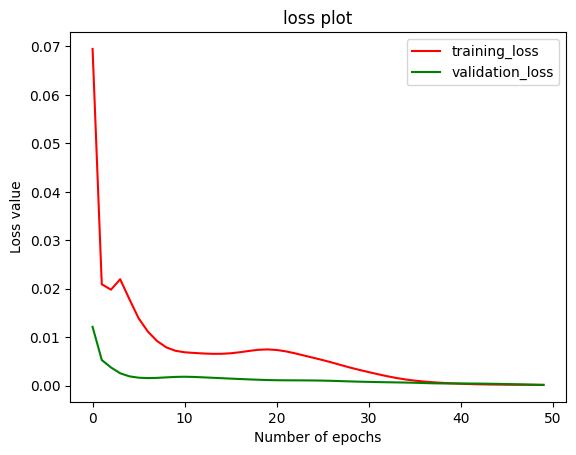

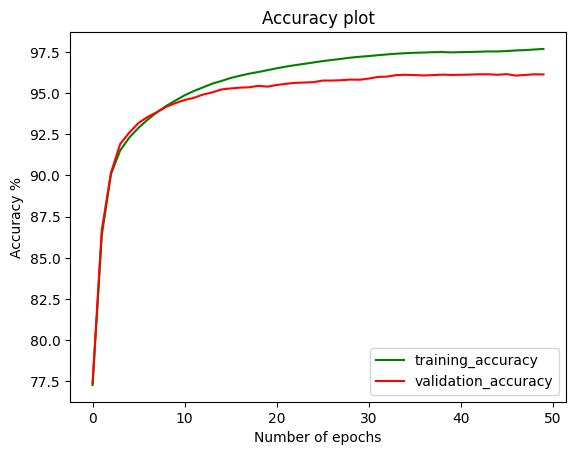

In [ ]:
dnn5 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=50, l_rate=0.05)
dnn5.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-6**

**DNN5** achieved **97.68%** training and **96.13%** validation accuracy. The performance is strong and consistent, with a small **overfitting** gap. However, it does not reach the peak performance of DNN1 and DNN4. Still, it is a reliable and **well-balanced model**.

Epoch: 1, Time Spent: 70.55s, Accuracy: 63.67%
Epoch: 1, Time Spent: 70.55s, Accuracy: 63.98%
Epoch: 1, Time Spent: 70.55s, loss: 0.30
Epoch: 1, Time Spent: 70.55s, loss: 0.15
-------------------------------------------------------------
Epoch: 2, Time Spent: 140.04s, Accuracy: 69.64%
Epoch: 2, Time Spent: 140.04s, Accuracy: 69.52%
Epoch: 2, Time Spent: 140.04s, loss: 0.26
Epoch: 2, Time Spent: 140.04s, loss: 0.10
-------------------------------------------------------------
Epoch: 3, Time Spent: 210.33s, Accuracy: 74.69%
Epoch: 3, Time Spent: 210.33s, Accuracy: 75.09%
Epoch: 3, Time Spent: 210.33s, loss: 0.20
Epoch: 3, Time Spent: 210.33s, loss: 0.06
-------------------------------------------------------------
Epoch: 4, Time Spent: 279.65s, Accuracy: 77.64%
Epoch: 4, Time Spent: 279.65s, Accuracy: 78.69%
Epoch: 4, Time Spent: 279.65s, loss: 0.13
Epoch: 4, Time Spent: 279.65s, loss: 0.02
-------------------------------------------------------------
Epoch: 5, Time Spent: 349.39s, Accur

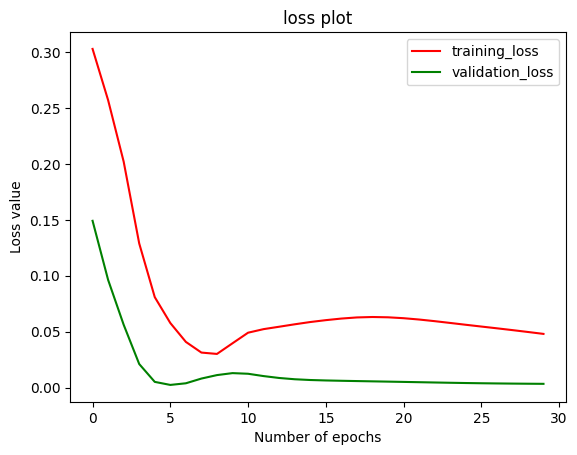

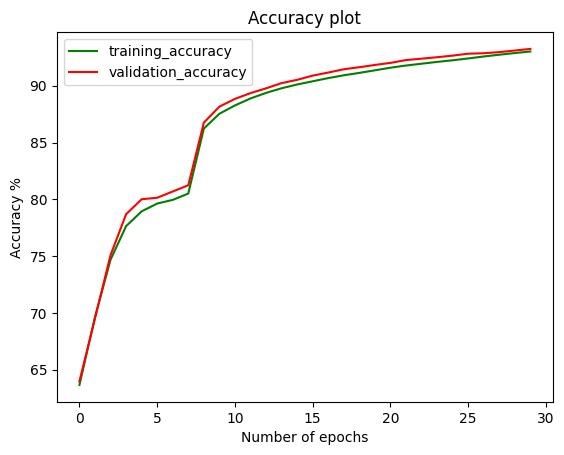

In [ ]:
dnn6 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=30, l_rate=0.01)
dnn6.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-7**

**DNN6** performed at **~93%** accuracy for both training and validation. This indicates **underfitting** — the model is not complex enough for this dataset. The accuracies being close suggests **stable learning** but not deep enough feature extraction.

Epoch: 1, Time Spent: 68.91s, Accuracy: 61.73%
Epoch: 1, Time Spent: 68.91s, Accuracy: 62.37%
Epoch: 1, Time Spent: 68.91s, loss: 1.72
Epoch: 1, Time Spent: 68.91s, loss: 0.10
-------------------------------------------------------------
Epoch: 2, Time Spent: 138.83s, Accuracy: 71.95%
Epoch: 2, Time Spent: 138.83s, Accuracy: 72.46%
Epoch: 2, Time Spent: 138.83s, loss: 1.72
Epoch: 2, Time Spent: 138.83s, loss: 0.06
-------------------------------------------------------------
Epoch: 3, Time Spent: 208.22s, Accuracy: 76.63%
Epoch: 3, Time Spent: 208.22s, Accuracy: 77.05%
Epoch: 3, Time Spent: 208.22s, loss: 1.72
Epoch: 3, Time Spent: 208.22s, loss: 0.03
-------------------------------------------------------------
Epoch: 4, Time Spent: 278.21s, Accuracy: 78.45%
Epoch: 4, Time Spent: 278.21s, Accuracy: 79.12%
Epoch: 4, Time Spent: 278.21s, loss: 1.72
Epoch: 4, Time Spent: 278.21s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 347.30s, Accur

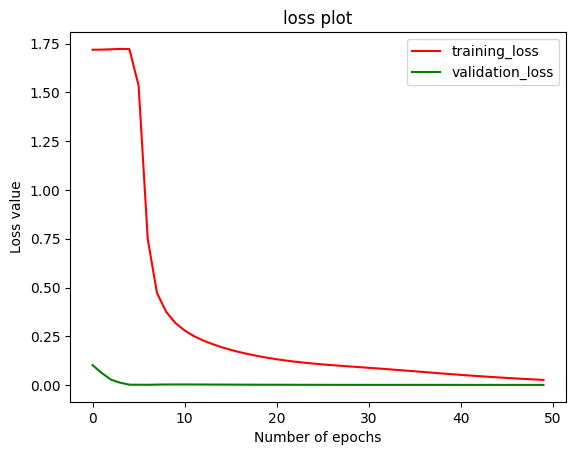

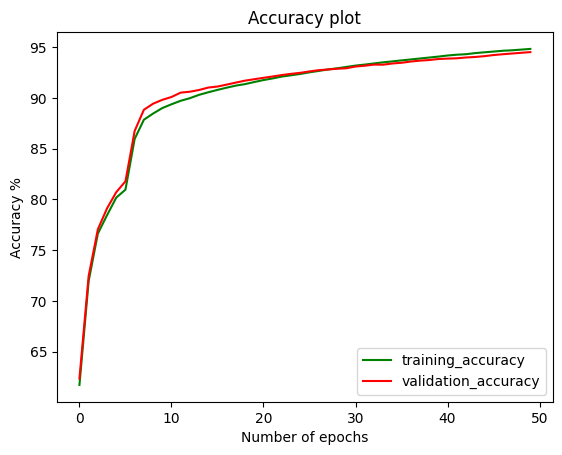

In [ ]:
dnn7 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=50, l_rate=0.01)
dnn7.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-8**

**DNN7** produced **94.8%** training accuracy and **94.5%** validation accuracy. This is **moderate performance**, showing good generalization but **lack of capacity** compared to the stronger models. It is stable but not highly accurate.

Epoch: 1, Time Spent: 68.95s, Accuracy: 75.03%
Epoch: 1, Time Spent: 68.95s, Accuracy: 75.95%
Epoch: 1, Time Spent: 68.95s, loss: 0.15
Epoch: 1, Time Spent: 68.95s, loss: 0.03
-------------------------------------------------------------
Epoch: 2, Time Spent: 137.76s, Accuracy: 80.11%
Epoch: 2, Time Spent: 137.76s, Accuracy: 80.89%
Epoch: 2, Time Spent: 137.76s, loss: 0.08
Epoch: 2, Time Spent: 137.76s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 206.81s, Accuracy: 85.03%
Epoch: 3, Time Spent: 206.81s, Accuracy: 85.82%
Epoch: 3, Time Spent: 206.81s, loss: 0.07
Epoch: 3, Time Spent: 206.81s, loss: 0.02
-------------------------------------------------------------
Epoch: 4, Time Spent: 276.10s, Accuracy: 88.30%
Epoch: 4, Time Spent: 276.10s, Accuracy: 88.99%
Epoch: 4, Time Spent: 276.10s, loss: 0.06
Epoch: 4, Time Spent: 276.10s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 344.62s, Accur

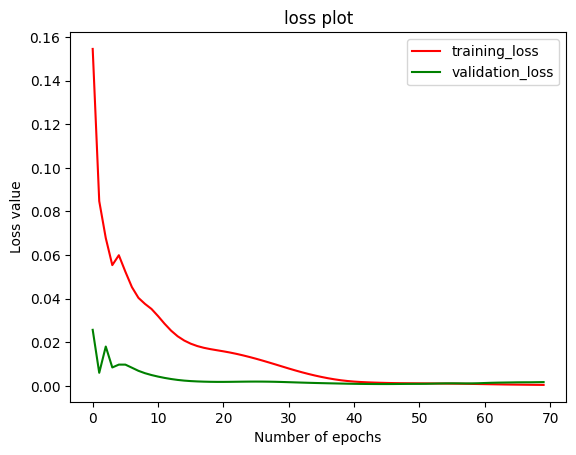

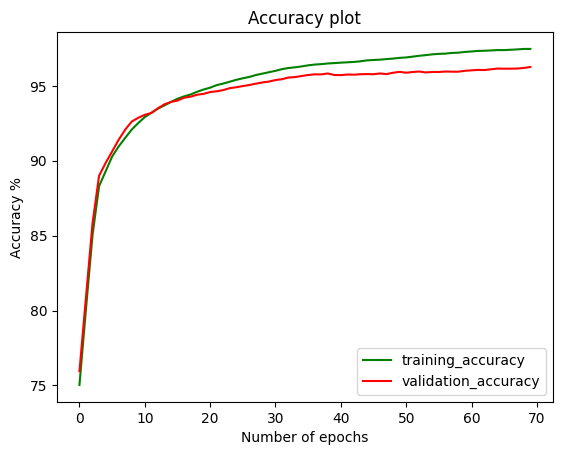

In [ ]:
dnn8 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=70, l_rate=0.03)
dnn8.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-9**

**DNN8** provided **97.47%** training accuracy and **96.26%** validation accuracy, making it a **well-performing model**. Its generalization is strong and close to DNN5, though still slightly behind the highest-accuracy models.

Epoch: 1, Time Spent: 37.13s, Accuracy: 77.61%
Epoch: 1, Time Spent: 37.13s, Accuracy: 78.52%
Epoch: 1, Time Spent: 37.13s, loss: 0.06
Epoch: 1, Time Spent: 37.13s, loss: 0.01
-------------------------------------------------------------
Epoch: 2, Time Spent: 74.20s, Accuracy: 85.35%
Epoch: 2, Time Spent: 74.20s, Accuracy: 86.74%
Epoch: 2, Time Spent: 74.20s, loss: 0.02
Epoch: 2, Time Spent: 74.20s, loss: 0.01
-------------------------------------------------------------
Epoch: 3, Time Spent: 111.29s, Accuracy: 89.69%
Epoch: 3, Time Spent: 111.29s, Accuracy: 90.30%
Epoch: 3, Time Spent: 111.29s, loss: 0.02
Epoch: 3, Time Spent: 111.29s, loss: 0.01
-------------------------------------------------------------
Epoch: 4, Time Spent: 148.27s, Accuracy: 91.33%
Epoch: 4, Time Spent: 148.27s, Accuracy: 91.90%
Epoch: 4, Time Spent: 148.27s, loss: 0.03
Epoch: 4, Time Spent: 148.27s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 184.67s, Accuracy:

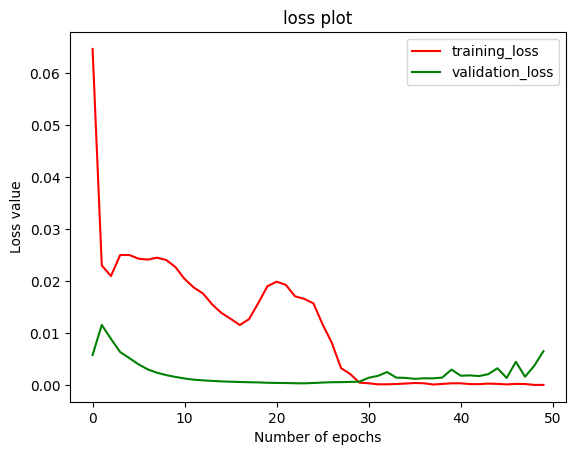

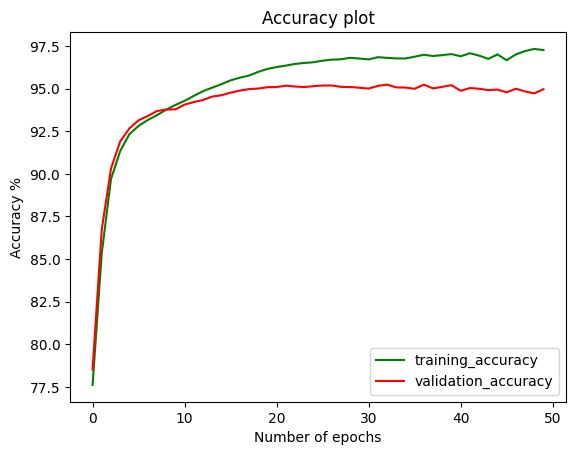

In [ ]:
dnn9 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.07)
dnn9.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-10**

**DNN9** reached **97.26%** training and **95.01%** validation accuracy. The overall performance is good, and the validation accuracy is respectable. However, the slightly larger gap suggests **mild overfitting** compared to similar models.

Epoch: 1, Time Spent: 72.36s, Accuracy: 65.72%
Epoch: 1, Time Spent: 72.36s, Accuracy: 65.87%
Epoch: 1, Time Spent: 72.36s, loss: 0.30
Epoch: 1, Time Spent: 72.36s, loss: 0.13
-------------------------------------------------------------
Epoch: 2, Time Spent: 143.94s, Accuracy: 70.66%
Epoch: 2, Time Spent: 143.94s, Accuracy: 71.50%
Epoch: 2, Time Spent: 143.94s, loss: 0.24
Epoch: 2, Time Spent: 143.94s, loss: 0.06
-------------------------------------------------------------
Epoch: 3, Time Spent: 214.65s, Accuracy: 75.34%
Epoch: 3, Time Spent: 214.65s, Accuracy: 76.12%
Epoch: 3, Time Spent: 214.65s, loss: 0.14
Epoch: 3, Time Spent: 214.65s, loss: 0.03
-------------------------------------------------------------
Epoch: 4, Time Spent: 285.59s, Accuracy: 76.86%
Epoch: 4, Time Spent: 285.59s, Accuracy: 77.79%
Epoch: 4, Time Spent: 285.59s, loss: 0.07
Epoch: 4, Time Spent: 285.59s, loss: 0.01
-------------------------------------------------------------
Epoch: 5, Time Spent: 355.26s, Accur

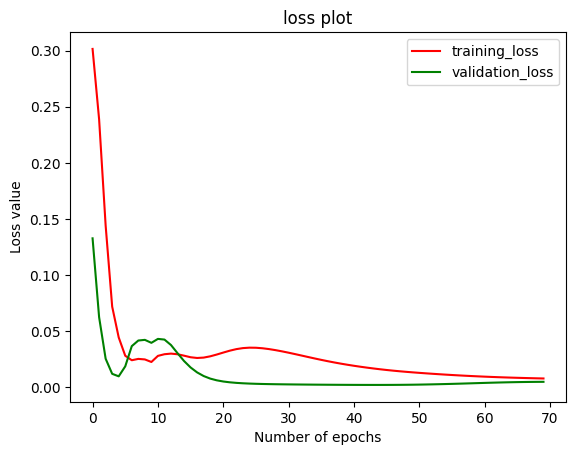

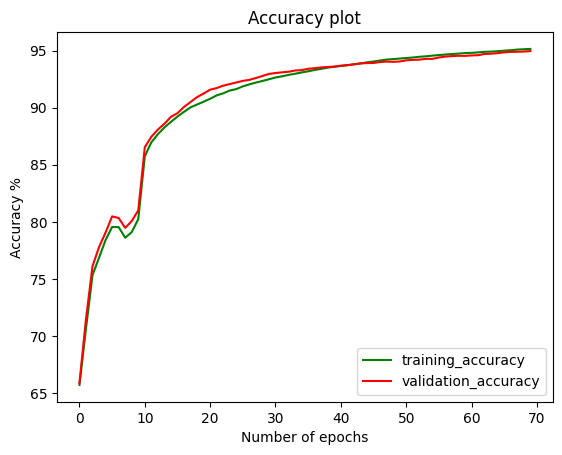

In [ ]:
dnn10 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=70, l_rate=0.01)
dnn10.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-11**

**DNN10** gave **95.15%** training and **94.96%** validation accuracy. The model is stable and shows **no overfitting**, but it lacks the necessary complexity to achieve very high accuracy. It performs **moderately well** but not exceptionally.

Epoch: 1, Time Spent: 73.59s, Accuracy: 63.66%
Epoch: 1, Time Spent: 73.59s, Accuracy: 64.32%
Epoch: 1, Time Spent: 73.59s, loss: 0.32
Epoch: 1, Time Spent: 73.59s, loss: 0.11
-------------------------------------------------------------
Epoch: 2, Time Spent: 144.92s, Accuracy: 72.31%
Epoch: 2, Time Spent: 144.92s, Accuracy: 72.68%
Epoch: 2, Time Spent: 144.92s, loss: 0.26
Epoch: 2, Time Spent: 144.92s, loss: 0.06
-------------------------------------------------------------
Epoch: 3, Time Spent: 215.52s, Accuracy: 75.34%
Epoch: 3, Time Spent: 215.52s, Accuracy: 76.01%
Epoch: 3, Time Spent: 215.52s, loss: 0.18
Epoch: 3, Time Spent: 215.52s, loss: 0.03
-------------------------------------------------------------
Epoch: 4, Time Spent: 286.59s, Accuracy: 77.68%
Epoch: 4, Time Spent: 286.59s, Accuracy: 78.25%
Epoch: 4, Time Spent: 286.59s, loss: 0.10
Epoch: 4, Time Spent: 286.59s, loss: 0.02
-------------------------------------------------------------
Epoch: 5, Time Spent: 357.07s, Accur

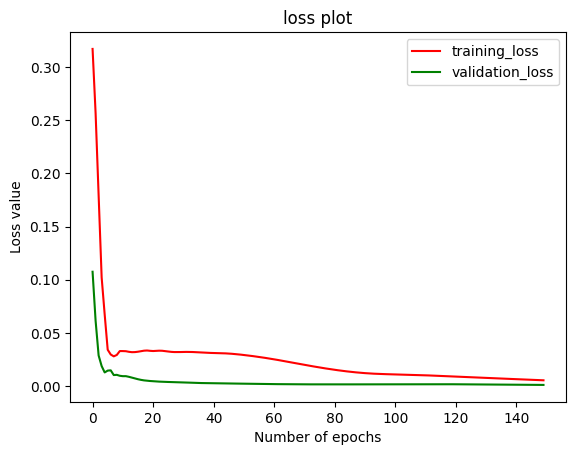

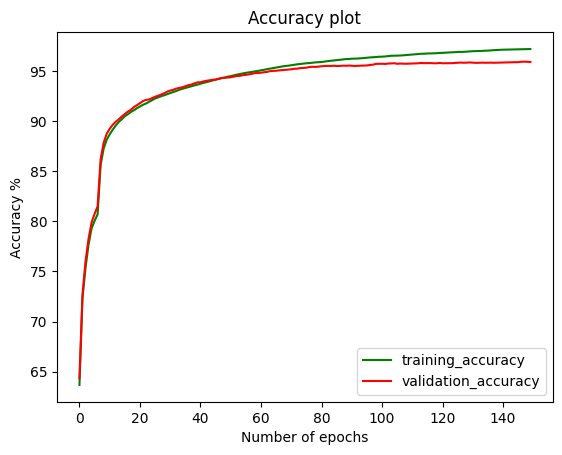

In [ ]:
dnn11 = DeepNeuralNetwork(sizes=[784, 256, 128, 10], epochs=150, l_rate=0.01)
dnn11.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

###**Observation-12**

**DNN11** achieved **97.23%** training and **95.94%** validation accuracy. The performance is **strong and balanced**. However, the validation accuracy is still lower compared to the top models. It’s a **good performer** but not the best.

##**Summary**

Across all trained models, **DNN1** and **DNN4** emerge as the best performers, both achieving very **high training accuracy** (around **98–99%**) and strong validation accuracy (**95–96%**). These models demonstrate excellent learning capability and good generalization, with only **slight overfitting**. Most of the remaining models show moderate performance, while **DNN** and **DNN6** clearly underfit, as reflected in their comparatively **low accuracy values**.

Based on the overall evaluation, **DNN4** is the **best-performing model**, achieving the highest validation accuracy of **95.70%**, which indicates superior generalization to unseen data. Although several models reached high training accuracy, **DNN4** provides the best balance between learning and generalization. Its architecture and hyperparameters make it the most **stable and reliable** among all tested configurations.

Therefore, **“DNN4 is the most suitable and effective choice for this MNIST classification task.”**

In [ ]:
sample = x_val[0].reshape(784)

out = dnn4.forward_pass(sample)

print("\nA0 (Input Layer):")
print(dnn4.params['A0'])

print("\nZ1 (Linear Layer 1):")
print(dnn4.params['Z1'])

print("\nA1 (Activation Layer 1):")
print(dnn4.params['A1'])

print("\nZ2 (Linear Layer 2):")
print(dnn4.params['Z2'])

print("\nA2 (Activation Layer 2):")
print(dnn4.params['A2'])

print("\nZ3 (Linear Output Layer):")
print(dnn4.params['Z3'])

print("\nA3 (Final Softmax Output):")
print(dnn4.params['A3'])



A0 (Input Layer):
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 

Output Vector : [ 0.     0.009  0.     0.004  0.    99.984  0.     0.     0.001  0.001]
Predicted Digit: 5
Confidence: 99.98%


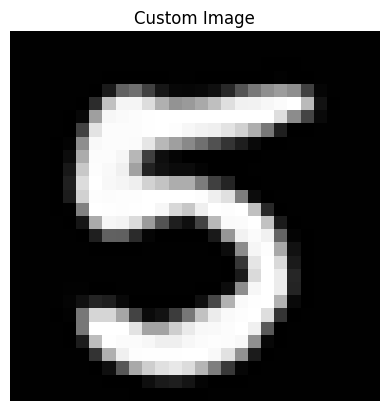

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_custom_image(path):

    img = Image.open(path).convert('L')
    img = img.resize((28, 28))
    img_arr = np.array(img)
    img_arr = 255 - img_arr
    img_arr = img_arr.astype('float32') / 255.0
    img_arr = img_arr.reshape(784)

    return img_arr

img_vector = preprocess_custom_image("/content/mnist_dream_10.png")

output_vector = dnn4.forward_pass(img_vector)
output_vector_100 = output_vector * 100
pred_digit = np.argmax(output_vector)
confidence = output_vector_100[pred_digit]

np.set_printoptions(precision=3, suppress=True)
print("Output Vector :", output_vector_100)
print("Predicted Digit:", pred_digit)
print(f"Confidence: {confidence:.2f}%")

plt.imshow(img_vector.reshape(28, 28), cmap='gray')
plt.title("Custom Image")
plt.axis('off')
plt.show()
